In [2]:
#Anything is edible if you eat it
#This notebook will be used to run  simulations
#
#12/07/2015

#This notebook will use the file "Practice_Tcav.kat" and follow the
#progression of iPython notebook "ISC_for_a_FP_cavity"

#Import stuff and read in base kat file
import pykat
import pylab as pl
%matplotlib inline
import pandas
from pandas import DataFrame

katfilename = "Practice_Tcav.kat"

basekat = pykat.finesse.kat()
basekat.loadKatFile(katfilename)
basekat.verbose = False

#constants
maxtem = 5
MHz = 1e-6
urad = 1e6
mW = 1e3

Saving data 100%
 --- cavity tracing
 cavity TMC:
  cavity is stable! Eigenvalues:
  qx=-1.0875+3.11299j, w0x=1.02679684161261mm zx=-1.0875m mx=0.782467
  qy=-1.0875+3.11352j, w0y=1.026884586199mm zy=-1.0875m my=0.782533
  finesse : 124.522, round-trip power loss: 0.049204 [/100]
  opt. length: 2.175m, FSR: 137.835612873563MHz
  FWHM: 1.10691756377865MHz (pole: 553.458781889327kHz)
  (x) RT Gouy: 38.5130022053715 deg, mode sep. 14.7457312849396MHz
  (y) RT Gouy: 38.5069052322591 deg, mode sep. 14.7433968959796MHz
 
 
 computation time:  4.2973s



<function matplotlib.pyplot.plot>

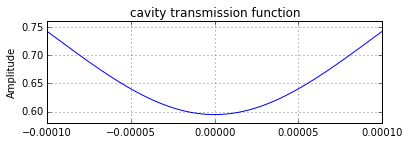

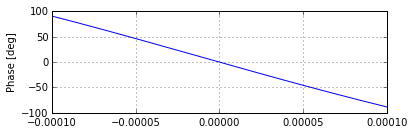

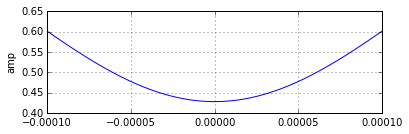

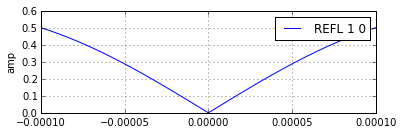

In [3]:


kat = basekat.deepcopy()
kat.maxtem = 5

#add amplitude detectors, one looking at cavity input field
#one looking at the cavity reflected field

kat.parseCommands("""
        trace 2
        ad adREFL 0 nMCREFL
        ad adIN 0 nMC1in*
        ad adREFL2 1 0 0 nMCREFL
        """)

#photodetector to plot the drop in reflection power around resonance

kat.parseCommands("""
        s REFLtoPD 0.1 nMCREFL nPD
        pd PDREFL nPD
        """)

#We'll make our x-axis variable PZT2 detuning
#for fun
#from sample, we'll vary mirror angle tuning

kat.parseCommands("""
        xaxis PZT2 xbeta lin -0.0001 0.0001 1000
       """
         )

#following command makes sure data is saved as complex numbers

kat.parseCommands("yaxis abs:deg")

#runs simulation and stores output in "outs"

out = kat.run(printerr=1)

#reflection function amplitude is reflection/input

refl_amp = abs(out["adREFL"])/abs(out["adIN"])
pd_amp = abs(out["PDREFL"])
refl2_amp = abs(out["adREFL2"])/abs(out["adIN"])


#reflection function phase is difference between reflection and 
#input

refl_phase = pl.angle(out["adREFL"])-pl.angle(out["adIN"])

#unwrap phase to avoid jumps of 2pi

refl_phase = pl.unwrap(refl_phase)*180/pl.pi


PZT2pos = out.x

#plot results


#plot of amplitude as a function of PZT2 misalignment. It is the combination of all modes.
pl.figure()
pl.subplot(211)
pl.plot(PZT2pos, refl_amp)
pl.title("cavity transmission function")
pl.ylabel("Amplitude")
pl.grid()
pl.plot

#phase
pl.figure()
pl.subplot(212)
pl.plot(PZT2pos,refl_phase,label="REFL phase")
pl.ylabel("Phase [deg]")
#pl.xlabel("ETM position detuning [nm]")
pl.grid()
pl.plot

#amplitude by PD
pl.figure()
pl.subplot(212)
pl.plot(PZT2pos,pd_amp,label="REFL phase")
pl.ylabel("amp")
#pl.xlabel("ETM position detuning [nm]")
pl.grid()
pl.plot

#misalignment of PZT2 mirror causes the creation of higher order mode, which is then rejected by the mode cleaner.
#this plot just looks at the reflection of the 1 0 mode.
pl.figure()
pl.subplot(212)
pl.plot(PZT2pos,refl2_amp,label="REFL 1 0")
pl.ylabel("amp")
#pl.xlabel("ETM position detuning [nm]")
pl.grid()
pl.legend()
pl.plot



Saving data 100%


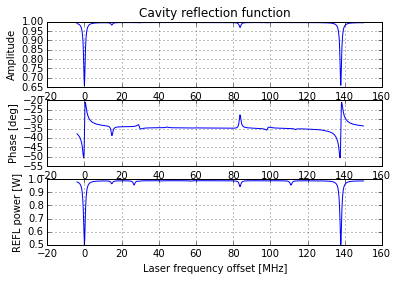

In [18]:
kat = basekat.deepcopy()
#edit parameters within your kat file by using
#mirror detuning to introduce HOM
kat.PZT2.xbeta = 0.00005
kat.PZT2.ybeta = 0.00005
kat.maxtem =5

#create function with func [name] = [function]


kat.parseCommands("""
        s REFLtoPD 0.1 nMCREFL nPD
        pd PDREFL nPD
        ad adREFL 0 nMCREFL
        ad adIN 0 nMC1in*
        yaxis abs:deg
        """)

kat.parseCommands("""
        xaxis laser f lin -4M 150M 1000
        put adREFL f $x1
        put adIN f $x1"""
        )

out=kat.run(printerr=1)

# reflection function amplitude is reflection divided by input
refl_amp = abs(out["adREFL"])/abs(out["adIN"])

# reflection function phase is difference between reflection and input
refl_phase = pl.angle(out["adREFL"])-pl.angle(out["adIN"])

# unwrap phase to avoid jumps of 2pi
refl_phase = pl.unwrap(refl_phase)*180/pl.pi

# plot the results
#plots normalized reflection function, HOM allowed
pl.figure()
pl.subplot(311)
pl.plot(out.x*MHz,refl_amp)
pl.title("Cavity reflection function")
pl.ylabel("Amplitude")
pl.grid()

#phase
pl.subplot(312)
pl.plot(out.x*MHz,refl_phase,label="REFL phase")
pl.ylabel("Phase [deg]")
pl.xlabel("Laser frequency offset [MHz]")
pl.grid()

#power
pl.subplot(313)
pl.plot(out.x*MHz,out["PDREFL"])
pl.ylabel("REFL power [W]")
pl.xlabel("Laser frequency offset [MHz]")
pl.grid()


Saving data 100%


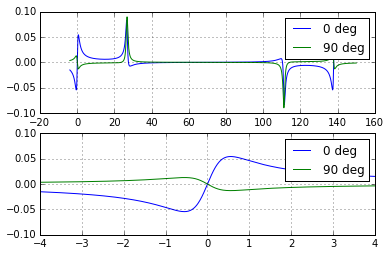

In [16]:
#Generate PDH signal using a modulator and this cavity
#there's a modulator already, tuned for f = fmod = 26.717 Mhz
#copy base kat
kat = basekat.deepcopy()

#introduce 2 photodiodes in reflection, for i and q detection
#Not tuned specifically
kat.parseCommands("""
        pd1 PD1 $fmod1 0 nMCREFL
        pd1 PD2 $fmod1 45 nMCREFL
""")

#We can sweep either laser frequency or cavity length to look
#at the PDH signal
kat.parseCommands("""
        xaxis laser f lin -4M 150M 10000
""")

#run the simulation!
out = kat.run(printerr=1)

laserf = out.x*MHz

pl.figure()
pl.subplot(211)
pl.plot(laserf, out["PD1"], label = "0 deg")
pl.plot(laserf, out["PD2"], label = "90 deg")
pl.legend()
pl.grid()
pl.subplot(212)
pl.plot(laserf, out["PD1"], label = "0 deg")
pl.plot(laserf, out["PD2"], label = "90 deg")
pl.legend()
pl.xlim(-4, 4)
pl.grid()

Saving data 100%
3068
306.8
  ** removing line 'diff laser f'
Removed existing object 'xaxis' of type <class 'pykat.commands.xaxis'> to add line 'xaxis laser f lin -40M 40M 10000'
Saving data 100%


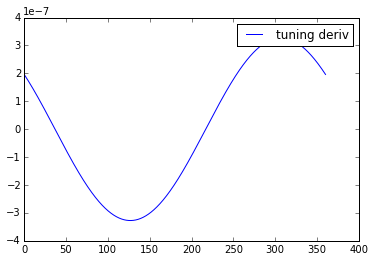

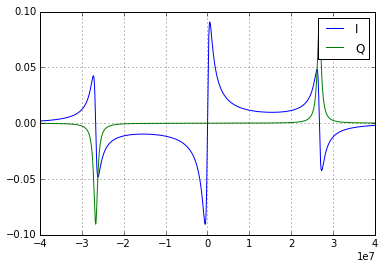

In [40]:
#Try to tune the demod phase so that all the PDH signal
#is in i (or what I'll cal i, at least)

kat = basekat.deepcopy()

#introduce two photodetectors as before, for i and q measurement (90 degrees appart)
kat.parseCommands("""
        pd1 PD1 $fmod1 0 nMCREFL
        pd1 PD2 $fmod1 90 nMCREFL
""")

#sample notebook then differentiates error signal with respect to change in end mirror
#length phi
#lets try differentiation wrt laser frequency instead
kat.parseCommands("diff laser f")

#on the x axis, we'll vary demodulation phase
kat.parseCommands("xaxis PD1 phase lin 0 360 3600")

out = kat.run(printerr=1)

pl.figure()
pl.plot(out.x, out["PD1"], label = "tuning deriv")
pl.legend()

#in this for loop, we go through x-values until we find the value for
#which max slope is found
slope = out["PD1"]
m = max(slope)
for i, j in enumerate(slope):
    if j == m:
        max_x = i
print max_x

phasemax = out.x[max_x]
print phasemax

#now we can add this optimal demodulation phase to the already added components
kat.PD1.phi1 = phasemax
kat.PD2.phi1 = phasemax + 90

#remove differentiation
kat.removeLine("diff")

#rerun simulation, set xaxis as in previous PDH sim
kat.parseCommands("xaxis laser f lin -40M 40M 10000")

out = kat.run(printerr=1)
frequency = out.x*MHz

pl.figure()
pl.plot(out.x, out["PD1"], label = "I")
pl.plot(out.x, out["PD2"], label = "Q")
pl.grid()
pl.legend()




Saving data 100%


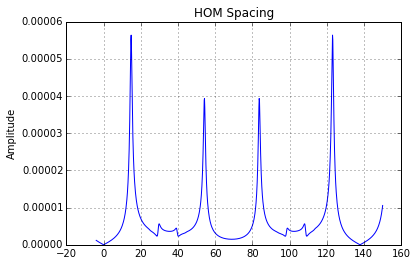

In [29]:
#HOM separation measurement
#copy stuff
kat = basekat.deepcopy()

#allow higher order modes and detune mirror to introduce them
kat.PZT2.xbeta = 0.00005
kat.PZT2.ybeta = 0.00005
kat.maxtem =5


#introduce photodiodes at transmission of MC3 and MC2
kat.parseCommands("""
        pd1 MC3trans $fmod1 nMCTRANS
        pd1 MC2trans $fmod1 nMC2trans
    """)

#set xaxis to be the modulation frequency of EOM
kat.parseCommands("""
        xaxis EOM1 f lin -4M 150M 1000
        put MC3trans f $x1
        put MC2trans f $x1
    """)

#run the simulation!
out = kat.run(printerr=1)

#data out from transmission of end mirror MC2 and out mirror MC3
trans_MC2 = abs(out["MC2trans"])
trans_MC3 = abs(out["MC3trans"])

transfer = trans_MC3/trans_MC2

#plot data

pl.figure()
pl.plot(out.x*MHz,trans_MC3)
pl.title("HOM Spacing")
pl.ylabel("Amplitude")
pl.grid()





In [ ]:
#Return to follwing ISC notebook
#Frequency dependence of PDH sensing gain for ETM(MC2) dither

kat = basekat.deepcopy()

#add dither signal to MC2 and sweep the dither frequency
kat.parseCommands("""
    fsig dither MC2 z 1 0
    xaxis dither f log 10 1M 1000
    """)


